<h2>2 Применение решающего дерева</h2>

In [4]:
import numpy as np
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [9]:
def get_data():
    f = open('data/german.data-numeric.txt', 'r')
    data = []
    for line in f:
        new_line = []
        for elem in line.split(' '):
            if elem != '' and elem != '\n':
                new_line.append(elem)
        data.append(new_line)
    return np.array(data)[:, :-1], np.array(data)[:, -1]

features, classes = get_data()

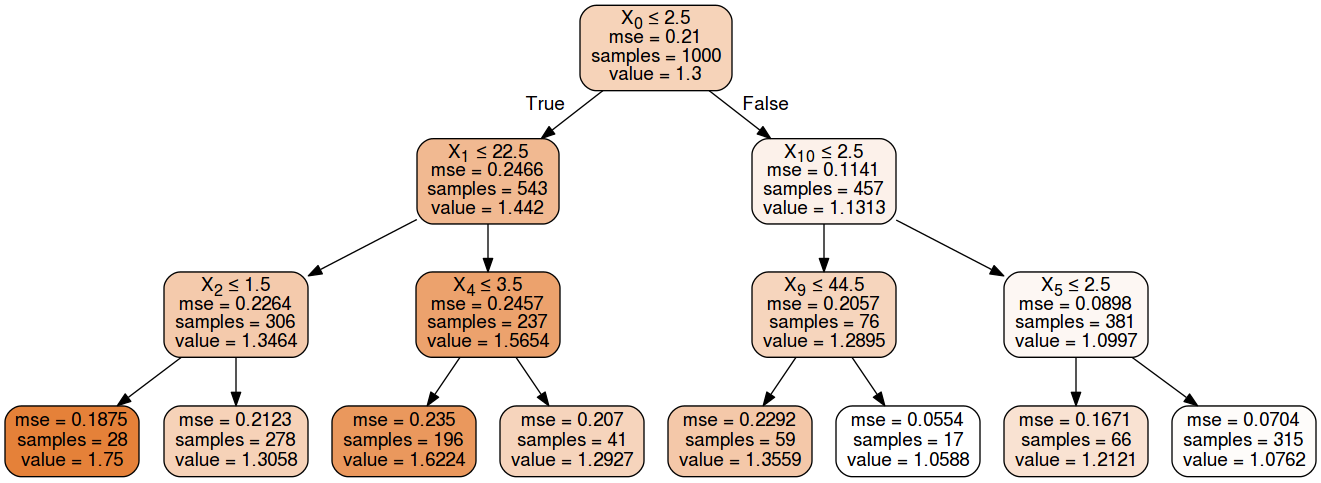

In [5]:
model = tree.DecisionTreeRegressor(max_depth=3)
model.fit(features, classes)
dot_data = tree.export_graphviz(model, out_file="small_tree.out",
                         class_names=classes,
                         filled=True, rounded=True,
                         special_characters=True)

graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")
Image(graph.create_png())

Интерпретация: <br>
Первая развилка - статус аккаунта, в ветку true идут существующие аккаунты с DM < 200. 
 <br>Второй слой слева направо. Лист 1 - продолжительность кредита в месяцах, лист 2 - деление на 2 категории - "есть поручитель" и "нет никого или есть еще один выплачивающий". 
 <br>Третий: лист 1 - выделяет тех, кто не брал кредитов, лист 2 - сумма кредита, и т.д.

Строим зависимость качества от глубины дерева на кросс-валидации и на обучающей выборке.

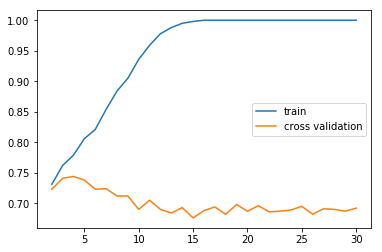

In [20]:
cross_val_acc = []
train_acc = []
N = 30
for i in range(N+1)[2:]:
    model = tree.DecisionTreeClassifier(max_depth=i)
    model.fit(features,classes)
    train_acc.append(accuracy_score(classes, model.predict(features)))
    cross_val_acc.append(np.mean(cross_val_score(model, features, classes)))

plt.plot(range(N+1)[2:], train_acc, label='train')
plt.plot(range(N+1)[2:], cross_val_acc, label='cross validation')
plt.legend()
plt.show()

<h2>3 Реализация решающего дерева</h2>

In [5]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [11]:
boston = load_boston()
X_train, X_test, Y_train, Y_test = train_test_split(boston.data, boston.target, test_size=0.25, random_state=42)

Будут два класса, для листа и для дерева. Сначала опишу класс листа. При инициализации мы отправляем объекту этого класса датасет (или чать датасета), и он определяет оптимальное разбиение, перебирая все значения признаков и сто значений барьера от минимального до максимального значения признака, считая ошибку (MSE) и записывая результат в переменную my_split в виде кортежа (признак, барьер). Так же инициализируется переменная my_children, в которой пото будут храниться следующие листья в дереве. Так же объект класса умеет возвращать разбиение датасета по своему барьеру и определять для данной точки, идти ей "влево" или "вправо" по дереву от этого листа (т.е. в какой из двух листов из my_children).

In [8]:
class leave:
    def __init__(self, X, Y):
        min_err = None
        min_err_split = None
        for i in range(len(X[0])):
            barriers = np.linspace(np.min(X[:, i]), np.max(X[:, i]), 100)
            for barrier in barriers:
                new_err, mean1, mean2 = self.error(X, Y, i, barrier)
                if not min_err or min_err > new_err:
                    min_err = new_err
                    self.mean1 = mean1
                    self.mean2 = mean2
                    min_err_split = (i, barrier)
        self.my_split = min_err_split
        self.my_error = min_err
        self.my_children = []

    def error(self, X, Y, index, barrier):
        left = [Y[i] for i in range(len(Y)) if X[i][index] <= barrier]
        right = [Y[i] for i in range(len(Y)) if X[i][index] > barrier]
        mean1 = np.mean(left)
        mean2 = np.mean(right)
        return 1.0 / len(Y) * (np.sum(map(lambda x: (x - mean1) ** 2, left))
                               + np.sum(map(lambda x: (x - mean2) ** 2, right))), mean1, mean2

    def split(self, X, Y):
        return np.array([X[i] for i in range(len(Y)) if X[i][self.my_split[0]] <= self.my_split[1]]), \
               np.array([Y[i] for i in range(len(Y)) if X[i][self.my_split[0]] <= self.my_split[1]]), \
                np.array([X[i] for i in range(len(Y)) if X[i][self.my_split[0]] > self.my_split[1]]), \
               np.array([Y[i] for i in range(len(Y)) if X[i][self.my_split[0]] > self.my_split[1]])

    def get_direction(self, elem):
        if elem[self.my_split[0]] <= self.my_split[1]:
            return 'left'
        else:
            return 'right'

Теперь класс дерева. При инициализации объекта инициализируем max_depth - максимальную глубину дерева и first_leave - корень дерева. <br>
В функции fit мы обучаем дерево: получаем датасет, создаем новый лист, добавляем его в my_children предшествующего в иерархии листа, делаем разбиение полученного датасета на "до барьера" и "после барьера" и рекурсивно запускаем fit на 2ух получившихся датасетах. При достижении максимальной глубины присваиваем my_children значение none и останавливаемся. <br>
Функция elem_value предсказывает значение на точке в пространстве признаков. Мы идем по листьям, начиная с корня, на каждом листе сравниваем элемент с барьером, определяем куда из листьев в my_children идти и вызываем elem_value уже на нем. Если my_children = none (достигли конца дерева), то возвращаем среднее по выделенным данным значение.
Функция predict просто вызывает elem_value для всех эелементов переданного датасета

In [9]:
class tree:
    def __init__(self, max_depth=5):
        self.first_leave = None
        self.max_depth = max_depth

    def fit(self, X, Y, cur_depth=0, parrent_leave=None):
        new_leave = leave(X, Y)
        if not parrent_leave:
            self.first_leave = new_leave
        else:
            parrent_leave.my_children.append(new_leave)
        if cur_depth < self.max_depth:
            X_left, Y_left, X_right, Y_right = new_leave.split(X, Y)
            if len(X_left) == 0 or len(X_right) == 0:
                new_leave.my_children = None
            else:
                self.fit(X_left, Y_left, cur_depth+1, new_leave)
                self.fit(X_right, Y_right, cur_depth+1, new_leave)
        else:
            new_leave.my_children = None

    def predict(self, X, cur_leave=None):
        return np.array([self.elem_value(elem) for elem in X])

    def elem_value(self, elem, cur_leave=None):
        if not cur_leave:
            cur_leave = self.first_leave
        direction = cur_leave.get_direction(elem)
        if cur_leave.my_children:
            if direction == 'left':
                return self.elem_value(elem, cur_leave.my_children[0])
            else:
                return self.elem_value(elem, cur_leave.my_children[1])
        else:
            if direction == 'left':
                return cur_leave.mean1
            else:
                return cur_leave.mean2

Проверем работоспособность дерева. Для этого, во первых, построим график с правильными значениями и предсказаниями на глубине 4, а во-вторых, графики среднеквадратичной ошибки для предсказаний на тренировочной и на тестовой выборках.

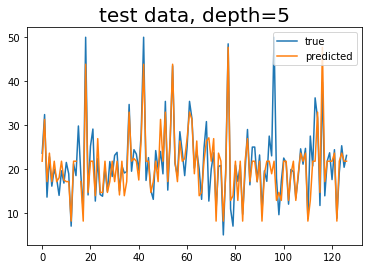

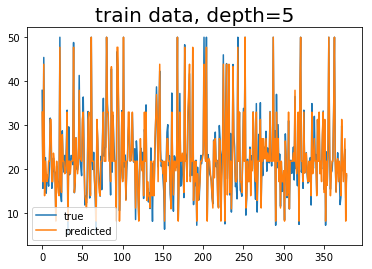

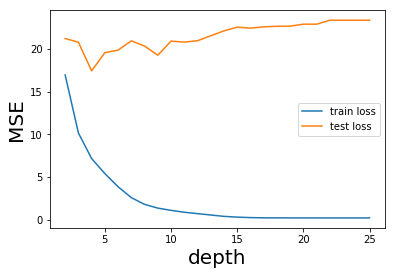

In [14]:
train_loss = []
test_loss = []
N = 25

for i in range(N+1)[2:]:
    model = tree(i)
    model.fit(X_train, Y_train)
    test_prediction =  model.predict(X_test)
    train_prediction = model.predict(X_train)
    if i == 5:
        plt.plot(range(len(Y_test)), Y_test, label='true')
        plt.plot(range(len(Y_test)), test_prediction, label='predicted')
        plt.title("test data, depth=5", fontsize=20)
        plt.legend()
        plt.show()
        
        plt.plot(range(len(Y_train)), Y_train, label='true')
        plt.plot(range(len(Y_train)), train_prediction, label='predicted')
        plt.title("train data, depth=5", fontsize=20)
        plt.legend()
        plt.show()
    train_loss.append(
        np.nanmean(map(lambda i: (train_prediction[i] - Y_train[i]) ** 2, range(len(Y_train)))))
    test_loss.append(
        np.nanmean(map(lambda i: (test_prediction[i] - Y_test[i]) ** 2, range(len(Y_test)))))

plt.plot(range(N+1)[2:], train_loss, label='train loss')
plt.plot(range(N+1)[2:], test_loss, label='test loss')
plt.xlabel("depth", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.legend()
plt.show()

<h2>Теоретические задачи</h2>

![alt text](1.jpg "1.1")
![alt text](3.jpg "1.3")